# Predicting The Outcome of Kickstarter Projects
Author: Matthew Huh


## What is Kickstarter

To put it in their own words “Kickstarter helps artists, musicians, filmmakers, designers, and other creators find the resources and support they need to make their ideas a reality. To date, tens of thousands of creative projects — big and small — have come to life with the support of the Kickstarter community.”

It is a platform that allows creators to transform ideas through the use of crowdfunding from backers in order to create tangible products. Creators set deadlines with funding goals that need to be met in order for them to create their projects, as well as stretch goals that may be created if that goal is surpassed. There is no guarantee that the creator will successfully create their project, or even meet expectations after the funding has been received. In addition, pledges are between backers and the creator, so refunds are left up to the creators. There is a lot of risk involved, but that is the nature of undertaking a kickstarter project. 

## About the Data

In this dataset lies a collection of 378,661 projects from April 2009 to January 2018 that contain a wide variety of project types and goals. The columns provided in the dataset are the
1. Project ID
2. Project name
3. Category
4. Main category
5. Currency type (USD,  EUR, GBP, etc.)
6. Deadline
7. Goal
8. Launch date
9. Pledged amount
10. State of the project (Successful, failed, cancelled, live, suspended)
11. Number of backers
12. Country of origin
13. USD pledged
14. USD pledged real
15. USD goal real

## Research Question

Now, the goal of this project is to determine what factors ultimately determine the success (or failure) of a kickstarter project, given the data and tools at our disposal. So the columns that we want to focus on out of these are variables that the project designer is in control of
1. Main category (15 categories)
2. Duration (deadline - launch date)
3. Goal (USD goal real specifically)
4. What month to launch
5. What day of the month to launch

A few extra variables that we will consider are 
4. Year
5. Currency
6. Country

The objective is to see if we can predict the state of the project given these predictors.

## Packages

In [1]:
# Basic import statements
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import HTML
import datetime
import timeit

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline

# (Optional) Plotly packages
import plotly as py
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

# Machine learning packages
from sklearn import ensemble, linear_model, preprocessing, tree
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, RFECV, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.utils import resample

C:\Users\mhuh22\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



## Data Preview

Let's begin by taking a took at our dataset. It contains a unique identifier for every project on the platform since it was created, and a few features that we can make use of in order to model the outcome.

In [2]:
# Import data and sort by deadline date
kickstart_data = pd.read_csv("ks-projects-201801.csv")

# Drop all empty rows
kickstart_data.dropna()

# Preview the data, ordered by deadline
kickstart_data.sort_values('deadline').head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
138572,1703704063,drawing for dollars,Illustration,Art,USD,2009-05-03,20.0,2009-04-24 21:52:03,35.0,successful,3,US,35.0,35.0,20.0
213711,2089078683,New York Makes a Book!!,Journalism,Journalism,USD,2009-05-16,3000.0,2009-04-28 13:55:41,3329.0,successful,110,US,3329.0,3329.0,3000.0
342226,813230527,Sponsor Dereck Blackburn (Lostwars) Artist in ...,Rock,Music,USD,2009-05-16,300.0,2009-04-29 05:26:32,15.0,failed,2,US,15.0,15.0,300.0
28960,1147015301,"""All We Had"" Gets Into Cannes -- $10 or More G...",Documentary,Film & Video,USD,2009-05-20,300.0,2009-04-30 22:10:30,40.0,failed,4,US,40.0,40.0,300.0
196244,199916122,Mr. Squiggles,Illustration,Art,USD,2009-05-22,30.0,2009-05-12 23:39:58,0.0,failed,0,US,0.0,0.0,30.0


In [3]:
# Check the size of our dataset
kickstart_data.shape

(378661, 15)

In [4]:
# Print out column names and # of unique values in each categorical variable
kickstart_data.select_dtypes(include=['object']).nunique()

name             375764
category            159
main_category        15
currency             14
deadline           3164
launched         378089
state                 6
country              23
dtype: int64

## Data Cleaning

In [5]:
# Convert 'launched' and 'deadline' columns into dates
kickstart_data['launched'] = kickstart_data['launched'].astype('datetime64[ns]')
kickstart_data['deadline'] = pd.to_datetime(kickstart_data['deadline'])
kickstart_data['launched'] = pd.DatetimeIndex(kickstart_data.launched).normalize()

# Project duration is more useful and less data
# than the launch date and deadline
kickstart_data['duration'] = kickstart_data['deadline'] - kickstart_data['launched']
kickstart_data['duration'] = (kickstart_data['duration'] / np.timedelta64(1, 'D')).astype(int)

# Create year variable from the deadline
kickstart_data['year'] = kickstart_data['launched'].dt.year
kickstart_data['launch_month'] = kickstart_data['launched'].dt.month
kickstart_data['deadline_month'] = kickstart_data['deadline'].dt.month
kickstart_data['day'] = kickstart_data['launched'].dt.day

# Drop the launch and duration now that we don't need them
kickstart_data.drop(['launched', 'deadline'], 1, inplace=True)

In [6]:
# Drop variables that have no impact on the outcome, and
# variables that have over 15 unique values
kickstart_data.drop(['ID', 'category', 'country', 'goal', 'pledged', 'usd pledged'], 1, inplace=True)

# Rename usd_pledged_real and usd_goal_real to 
# pledged and goal
kickstart_data = kickstart_data.rename(index=str, columns = {'usd_pledged_real': 'pledged', 
                                                             'usd_goal_real': 'goal', 
                                                             'main_category': 'category'})

In [7]:
# Clean the name column
kickstart_data['name'] = kickstart_data['name'].str.lower()
kickstart_data['name'] = kickstart_data['name'].str.replace('[^\w\s]','')
kickstart_data['name'] = kickstart_data['name'].str.strip()

# Save name length as a new variable
kickstart_data['name_length'] = kickstart_data['name'].str.split(" ").str.len()

# Drop name from the dataset
kickstart_data.drop(['name'], 1, inplace=True)

## Exploratory Data Analysis

In [8]:
# Summary of the dataset
kickstart_data.describe()

,backers,pledged,goal,duration,year,launch_month,deadline_month,day,name_length
count,378661.000000,3.786610e+05,3.786610e+05,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378657.00000
mean,105.617476,9.058924e+03,4.545440e+04,34.481095,2014.247829,6.461550,6.720726,15.294142,5.69296
std,907.185035,9.097334e+04,1.152950e+06,65.909173,1.933293,3.330133,3.342550,8.808409,2.77218
min,0.000000,0.000000e+00,1.000000e-02,1.000000,1970.000000,1.000000,1.000000,1.000000,1.00000
25%,2.000000,3.100000e+01,2.000000e+03,30.000000,2013.000000,4.000000,4.000000,8.000000,3.00000
50%,12.000000,6.243300e+02,5.500000e+03,30.000000,2014.000000,7.000000,7.000000,15.000000,5.00000
75%,56.000000,4.050000e+03,1.550000e+04,37.000000,2016.000000,9.000000,10.000000,23.000000,8.00000
max,219382.000000,2.033899e+07,1.663614e+08,16739.000000,2018.000000,12.000000,12.000000,31.000000,41.00000


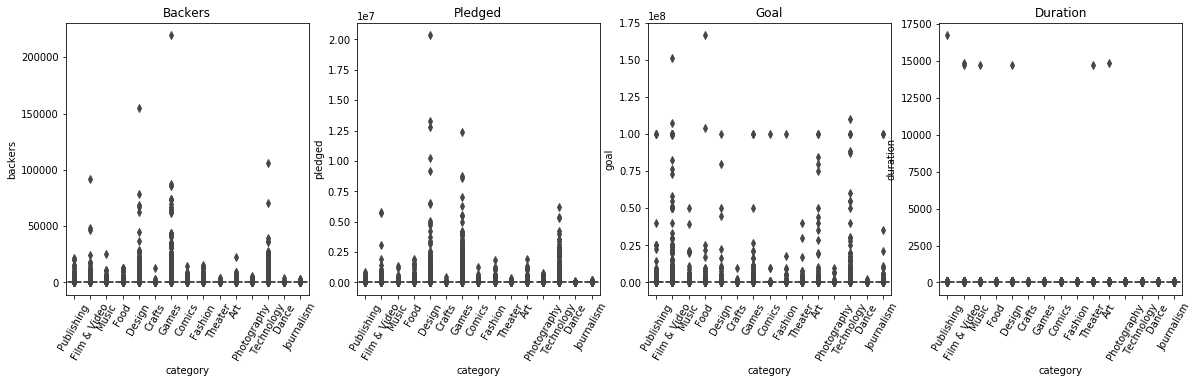

In [9]:
# Plot all of variables, and try to identify outliers# Plot  
plt.rcParams['figure.figsize'] = [20,5]

plt.subplot(1,4,1)
plt.title('Backers')
plt.xticks(rotation=60)
ax = sns.boxplot(x="category", y="backers", data=kickstart_data)

plt.subplot(1,4,2)
plt.title('Pledged')
plt.xticks(rotation=60)
ax = sns.boxplot(x="category", y="pledged", data=kickstart_data)

plt.subplot(1,4,3)
plt.title('Goal')
plt.xticks(rotation=60)
ax = sns.boxplot(x="category", y="goal", data=kickstart_data)

plt.subplot(1,4,4)
plt.title('Duration')
plt.xticks(rotation=60)
ax = sns.boxplot(x="category", y="duration", data=kickstart_data)

Well, one of the great things about Kickstarter is that there are technically no limits to the scale of the projects that can emerge from the platform. Feel free to look at Star Citizen if you were wondering what project generated over 2 million dollars in pledges.

<a href="https://www.kickstarter.com/projects/cig/star-citizen">Star Citizen</a>



So, the problem is that there are quite a lot of ambitious projects that drew in a substantial amount of backers with goals far above 75% of other projects, resulting in the messy distribution above. The duration variable looks like there are few enough genuine outliers for us to examine. As for the rest, it seems like we'll need to transform them before proceeding because there are simply too many outliers for us to ignore.

In [10]:
# Order by duration
kickstart_data.sort_values('duration', ascending = False).head(10)

,category,currency,state,backers,pledged,goal,duration,year,launch_month,deadline_month,day,name_length
319002,Publishing,CHF,suspended,0,0.0,1905.97,16739,1970,1,10,1,4.0
2842,Film & Video,USD,canceled,0,0.0,5000.00,14867,1970,1,9,1,9.0
48147,Art,USD,canceled,0,0.0,15000.00,14835,1970,1,8,1,8.0
94579,Theater,USD,canceled,0,0.0,4000.00,14761,1970,1,6,1,9.0
75397,Film & Video,USD,canceled,0,0.0,700.00,14750,1970,1,5,1,3.0
247913,Music,USD,canceled,0,0.0,10000.00,14733,1970,1,5,1,16.0
273779,Design,USD,canceled,0,0.0,500.00,14709,1970,1,4,1,4.0
200310,Film & Video,USD,failed,0,0.0,250000.00,92,2011,1,4,2,3.0
38476,Technology,USD,failed,1,100.0,65000.00,92,2011,3,6,15,4.0
305126,Film & Video,USD,failed,4,1530.0,20000.00,92,2011,1,4,2,4.0


As we had expected earlier, it seems as though out of 370,000+ projects, only 7 of them seem to have a suspiciously long duration at well over 10,000 days. The rest of the projects in this dataset last no more than 92 days. It seems as though the reason for this difference is because they have a start date with the year, 1970. Kickstarter was launched in 2009, so this is clearly an error. Since this is an extremely small subset of rows from our dataframe, we can safely remove these rows from the dataset before proceeding.

In [11]:
# Drop our 7 outliers from the dataset based on duration
kickstart_data.drop(kickstart_data.sort_values('duration', ascending = False).head(7).index, axis=0, inplace = True)

In [12]:
# Applying log transformations to 'goal' column
kickstart_data['goal'] = np.log(kickstart_data['goal'] + 1)

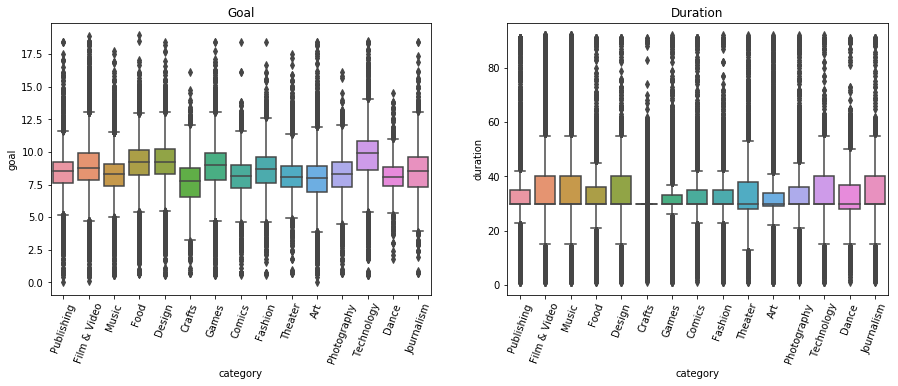

In [13]:
# Plot all of variables, and try to identify outliers
plt.rcParams['figure.figsize'] = [15,5]

plt.subplot(1,2,1)
plt.title('Goal')
plt.xticks(rotation=70)
ax = sns.boxplot(x="category", y="goal", data=kickstart_data)

plt.subplot(1,2,2)
plt.title('Duration')
plt.xticks(rotation=70)
ax = sns.boxplot(x="category", y="duration", data=kickstart_data)

So after removing our outliers from the 'duration' column, and applying a log transformation to the 'backers', 'pledged', and 'goal' columns, we can see a somewhat normal distribution.

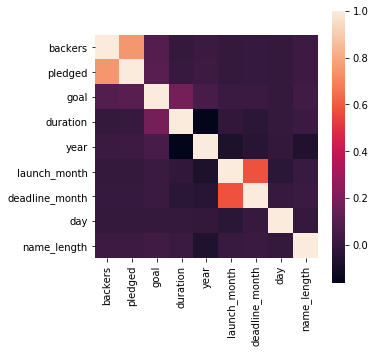

In [14]:
# Creates a correlation matrix among the predictor variables
plt.rcParams['figure.figsize'] = [5,5]

correlation_martix = kickstart_data.corr()
sns.heatmap(correlation_martix, vmax = 1, square = True)
plt.show()

There appears to be a very high degree of similarity between the number of backers, and total monetary amount contributed. This makes sense if we assume that each backer donates roughly the same amount, leading to two columns that have quite a lot in common. We can try removing one or the other later if we need to determine which of these factors is more important than the other. For now, we'll use both predictors in our model.

In [15]:
# Drop backers and pledged from the dataset since they are dependent variables
kickstart_data.drop(['backers', 'pledged'], 1, inplace=True)

(-1.2248786255360546,
 1.2131965717027007,
 -1.212274366954329,
 1.2109555139336867)

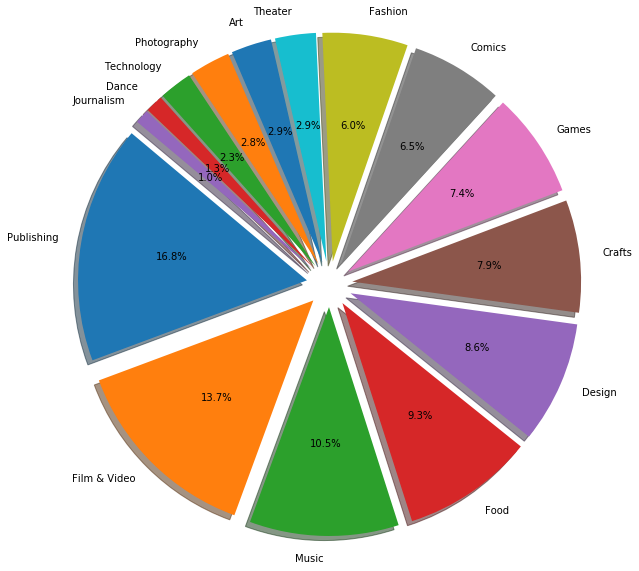

In [16]:
plt.rcParams['figure.figsize'] = [10,10]

# Creates a pie chart that represents the different categories in our dataset
plt.pie(kickstart_data['category'].value_counts(), explode = np.ones(15)*0.1, labels=kickstart_data['category'].unique(),
        labeldistance = 1.1, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

Kickstarter divides their main categories into 14 distinct groups of unequal size. Publishing, at 16.8% (63,000 projects), is the largest category in the dataset, while journalism is a little under 1% (3768 projects). While the distribution is unfortunately unbalanced, that is the data that we have, and we still have plenty of observations for each category to work with.

In [17]:
# This pie chart looks a lot better, but it does not play well with github due to its interactivity
# To view plotly images, please copy/paste this url to https://nbviewer.jupyter.org/

# Pass in values for our pie chart
trace = go.Pie(labels=kickstart_data['category'].unique(), values = kickstart_data['category'].value_counts())

# Create the layout
layout = go.Layout(
    title = 'Kickstarter Projects by Category',
    height = 600,
    width = 800,
    autosize = False
)

# Construct the chart
fig = go.Figure(data = [trace], layout = layout)
py.offline.iplot(fig, filename ='cufflinks/simple')

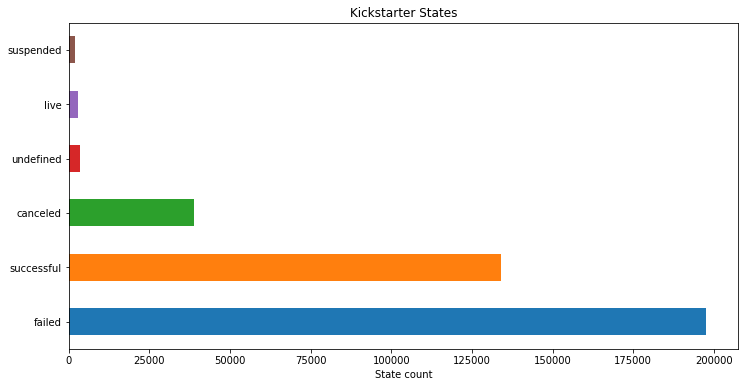

In [18]:
# Plot kickstarter states
plt.rcParams['figure.figsize'] = [12,6]
plt.title('Kickstarter States')
plt.xlabel('State count')
kickstart_data['state'].value_counts().plot(kind='barh')

So in this dataset, the six possible states for a project are suspended, live, undefined, canceled, successful, and failed. The first three states have very few values, relative to what we really want to know - if a project succeeds or fails. In addition, if we do want to utilize these three columns, we would need to look at the following factors.
1. A follow up to investigate the reason for a project to be suspended
2. Live projects can fall into either category - success or failure
3. Undefined is a result that we can't interpret or use.

Success and failure are easy to define, and can be recoded as 1 and 0 so that we can predict the outcome as an easily modelable binary variable. Cancellation is generally caused by the inability to meet a project's demands for a multitude of reasons leading to lack of funding, planning, or budgeting.. It would simplify the following models to treat cancellation the same as failure, 0.

In [19]:
# Remove 'suspended', 'live', and 'undefined' states from the dataset
kickstart_data = kickstart_data[kickstart_data.state != ('suspended', 'live', 'undefined')]

# Consolidate 'canceled' and 'failed' into one category
kickstart_data['state'] = np.where(kickstart_data.state == 'successful', 1, 0)
success_rate = kickstart_data['state']

(-1.1154681955525665,
 1.1143348565040996,
 -1.1132377615610414,
 1.117099503783597)

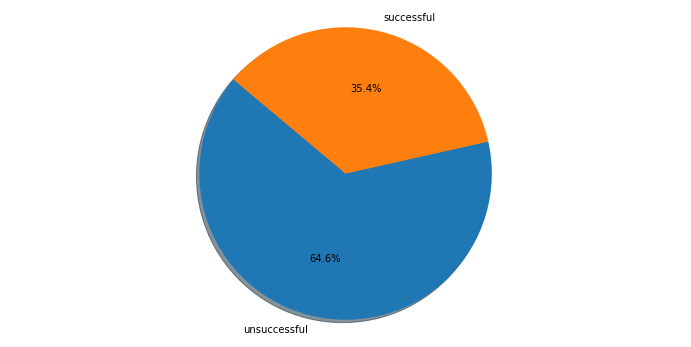

In [20]:
# Constructs a pie chart displaying our final successful and unsuccessful values
plt.pie(np.bincount(success_rate), labels=['unsuccessful', 'successful'],
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

After removing 3 of the project states, and combining cancelled and failed into 1 state, we end up with 35.4% projects succeeding, and 67.6% failing. The outcome is a bit unbalanced, so it will be necessary to keep in mind that there will most likely be some bias in the predictive variables towards unsuccessful projects.

In [21]:
plt.rcParams['figure.figsize'] = [15,5]

def percent_extraction (feature):
    # Finds percentages of all values in a category
    container = kickstart_data.groupby([feature, 'state'])[feature].count().unstack('state')
    totals = kickstart_data.groupby([feature])['state'].count()
    container = container.div(totals, axis = 0)
    
    # Plots the bar chart
    container.columns = ['unsuccessful', 'successful']
    container.plot(kind='bar', stacked=True)
    plt.title('Kickstarter success by {}'.format(feature))
    plt.axhline(y=0.646, color='r', ls='--')
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    plt.show()

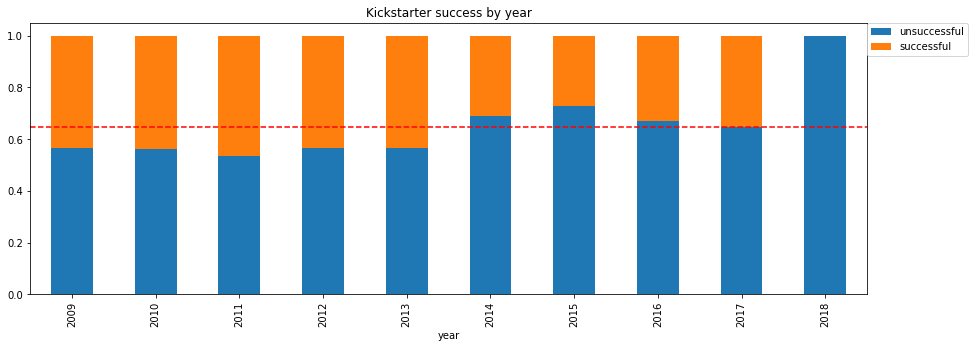

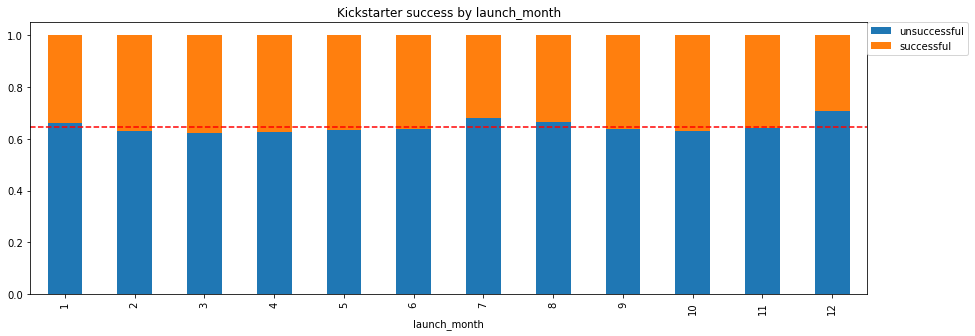

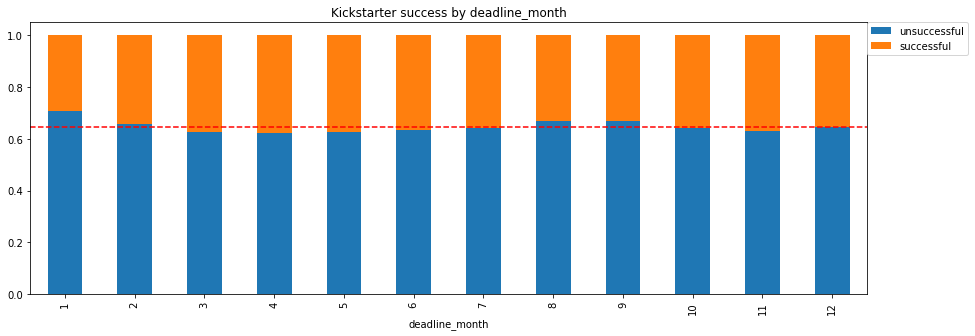

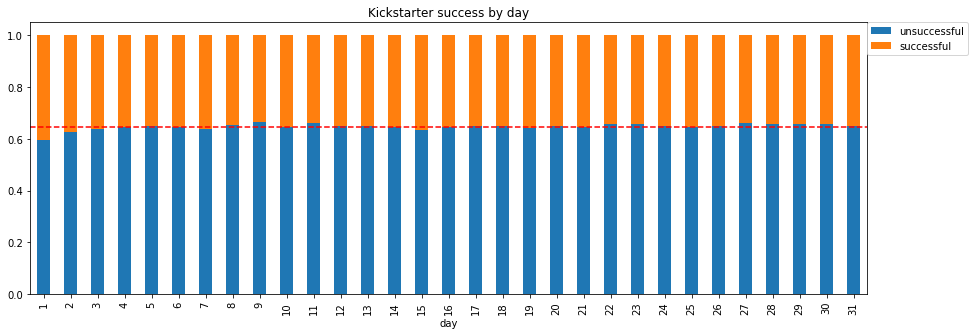

In [22]:
# View success rate bu year, launch month, deadline month, and day of month
percent_extraction('year')
percent_extraction('launch_month')
percent_extraction('deadline_month')
percent_extraction('day')

<div class="alert alert-block alert-warning">
The dotted red line above represents the line between success/ failure in the entire dataset.
</div>

Based on the observations from kickstarter success rates with respect to year, month, and day, we can observe some trends. 

By examining the success rates with respect to year the first thing that should scream out is that the success rate in 2018 is 0. This should not be very surprising given that the year column has been extracted from the deadline date, and that this dataset terminates in January 2018. It would make sense to remove projects with an end date in 2018 given the limitations of this dataset.

What we can see in our month columns is that month doesn't quite have too much of an impact, but it seems as though the worst month to launch is December and worst to end on is January. This is most likely due to the holiday season. If you want every edge you can as a creator, make sure to avoid the season.

Once again, not too much variance with the day, but the best time to try appears to be on the 1st.

In [23]:
# Drop rows where the deadline is in 2018
kickstart_data[kickstart_data.year != 2018];

In [24]:
# Normalize year column for modelling by changing from 2009 - 2018 to 0 - 9
kickstart_data['year'] = kickstart_data['year'] - 2009

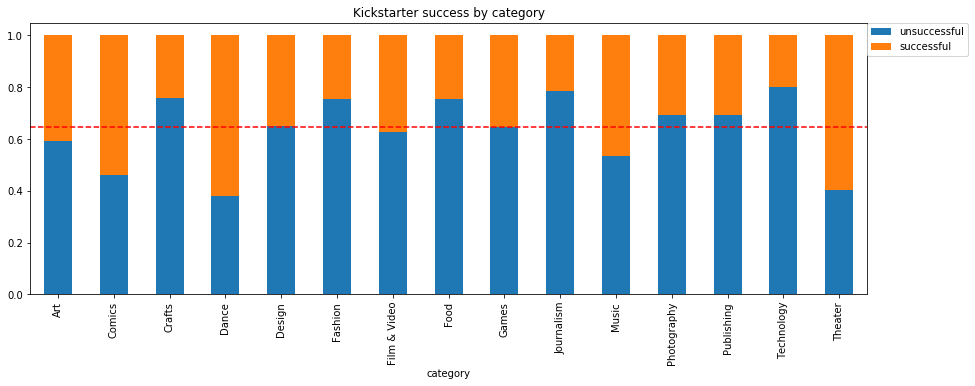

In [25]:
percent_extraction('category')

Earlier in the page, we investigated the size of each category in the dataset, and noticed that the groups are not equal, meaning some groups have a higher impact on the average outcome than others. Above, we see that the categories do not mirror the average results with some categories being much more successful than not, such as dance and theater, while certain others don't fare quite as well such as journalism and technology.

In [26]:
kickstart_data.groupby(['currency']).size()

currency
AUD      7950
CAD     14962
CHF       767
DKK      1129
EUR     17405
GBP     34132
HKD       618
JPY        40
MXN      1752
NOK       722
NZD      1475
SEK      1788
SGD       555
USD    295359
dtype: int64

As an American company and one of the largest countries in the list, it's not too surprising to see that the vast majority of projects are backed by the US dollar. Given the vast difference in population size of the projects, this may not be the most useful category for prediction, but we'll keep it for now and see if it makes it past the feature selection process.

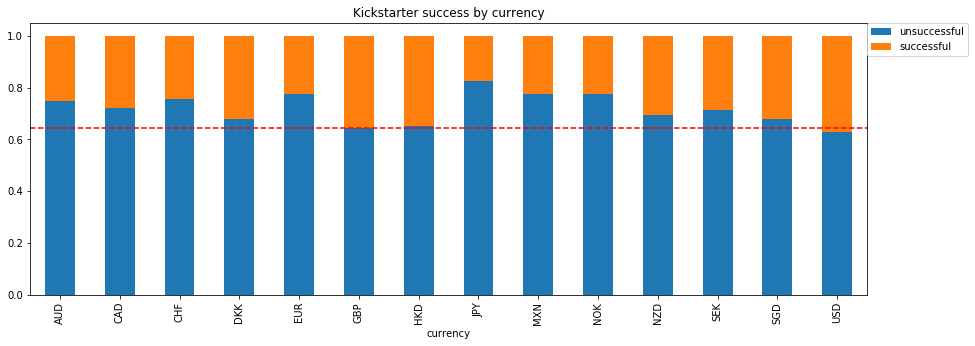

In [27]:
percent_extraction('currency')

Well isn't that ... not all that interesting? It seems like only 2 of the currencies have a success rate greater than average, one of which is the US, which heavily skews the result. The success rate is quite a bit lower in the majority of other available currencies, but it hardly has an impact on the average.

In [28]:
# Create separate dataframe for numerical values
numerical = kickstart_data.select_dtypes(exclude=['object'])

# Create separate dataframe for categorical values
categorical = pd.get_dummies(kickstart_data.select_dtypes(include='object'))

# Create the combined dataframe
kickstart_data = pd.concat([numerical, categorical], axis=1, sort = False)

In order to make use of the categorical variables in the dataset, category and country, they'll first need to be recoded to 1s and 0s so that they can be interpretted.

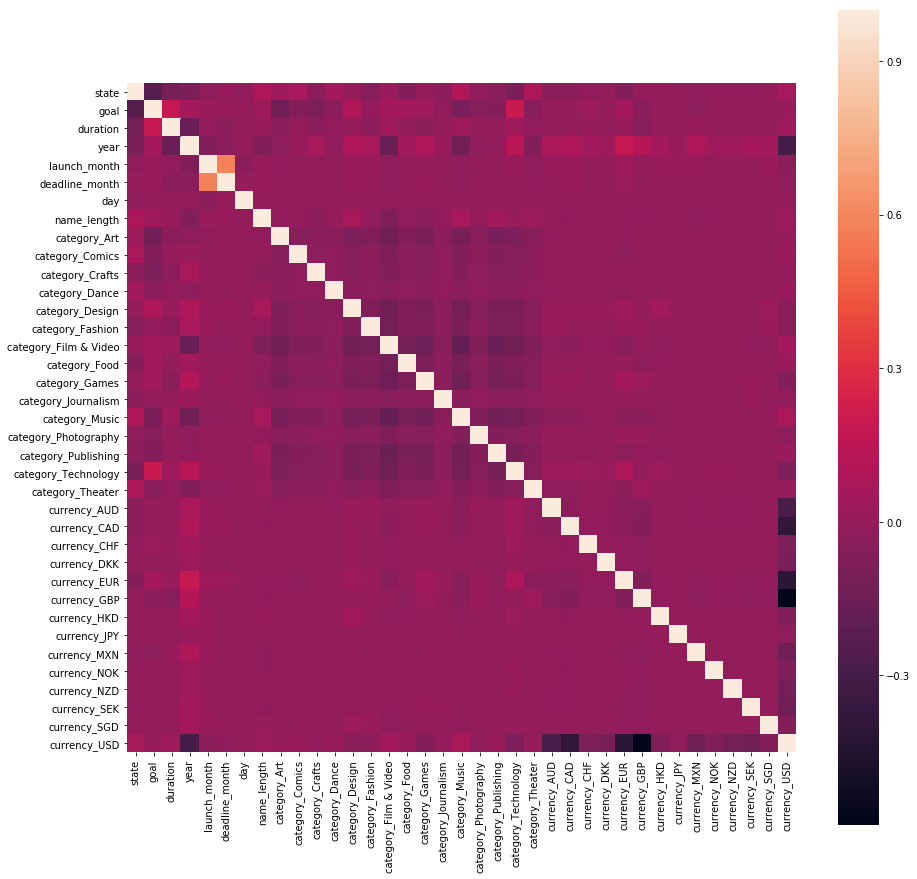

In [29]:
plt.rcParams['figure.figsize'] = [15,15]

# Creates a correlation matrix among the predictor variables
correlation_martix = kickstart_data.corr()
sns.heatmap(correlation_martix, vmax = 1, square = True)
plt.show()

By re-examining our correlation matrix after recoding the categorical variables (category and currency), the results are the same as before, except we can also confirm that the different values in category and country have no correlation to each other, or any other variable.

Now that we've examined and prepared our dataset, it's time to get to the fun part, modeling.

# Modelling

### Feature Selection

In order to expedite the modelling process, remove any potential overfitting, and decrease runtimes, we will be reducing the size of the dataset and apply feature selection. To maintain a sufficient sample size, we will still be keeping ⅓ of the dataset, and as for feature selection, we will be limiting it to the 10 (of 34)  best features using the SelectKBest algorithm.

In [30]:
# Separate majority and minority outcomes
df_majority  = kickstart_data[kickstart_data.state==0]
df_minority = kickstart_data[kickstart_data.state==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=kickstart_data.state.value_counts().max(),
                                 random_state=123)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [31]:
# Drop any remaining issues before the modelling phase
df_upsampled.dropna(inplace=True)

# Samples data
df_upsampled = df_upsampled.sample(frac=0.33, replace=True)

# Create a series with the target data
y = df_upsampled['state']

# Remove the 'state' column from our dataset
# since it's not a predictor, it's the outcome
df_upsampled.drop(['state'], axis = 1, inplace = True)

In [32]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_upsampled)
df_normalized = pd.DataFrame(np_scaled)

In [33]:
# Select 10 best features
kclassifier = SelectKBest(f_classif, k=10)
X = kclassifier.fit_transform(df_upsampled, y)

# Retrieve feature names
mask = kclassifier.get_support()
column_names = df_upsampled.columns[mask]

# Create new dataframe with k best features
X = pd.DataFrame(data=X, columns=column_names)

In [34]:
# Divide the dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=0)

## Logistic Regression Model

Let's start out with one of the simplest and quickest models for predicting outcomes, logistic regression. This model will determine the correlation between each of our predictor variables and outcome, then weigh the correlations depending on the strength of the relationships in order to construct the line of best fit. 

We'll start with a standard logistic regression model with L2 (Ridge) penalty, then test if using an L1 (Lasso) penalty and modifying the cost penalty will have any improvement in our model. Lastly, we'll examine if implementing feature selection will improve the accuracy by removing any overfitting from an excess number of variables.

In [35]:
lr = LogisticRegression(random_state=0)

# Parameters for logistic regression model
param_grid = {'penalty': ['l1', 'l2'],
              'C': [1, 10, 100, 1000]}

# Run grid search to find ideal parameters
start_time = timeit.default_timer()
lr_grid = GridSearchCV(lr, param_grid, cv=5, n_jobs=-2)
elapsed_lr = timeit.default_timer() - start_time

# Fitting the parameters to the data
lr_grid.fit(X_train, y_train)

# Reports best model parameters and accuracy
print(lr_grid.best_params_)
print(lr_grid.best_score_)

{'C': 1, 'penalty': 'l1'}
0.6250563914762625


In [36]:
# Store the predicted values in a dataframe
y_pred = lr_grid.predict(X_test)

In [37]:
# Create a confusion matrix
confusion_matrix(y_test, y_pred)

array([[15164,  9028],
       [ 9070, 15188]], dtype=int64)

In [38]:
# Print model statisitcs
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.63      0.63      0.63     24192
          1       0.63      0.63      0.63     24258

avg / total       0.63      0.63      0.63     48450



In [39]:
# Checks the accuracy of the model using cross validation
lr_cross_val = cross_val_score(lr_grid, X, y, cv=5, n_jobs=-2)  
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(lr_cross_val.mean(), lr_cross_val.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.62560(+/- 0.01)


Optimal number of features: 10
Selected features: ['goal', 'duration', 'year', 'name_length', 'category_Comics', 'category_Music', 'category_Technology', 'category_Theater', 'currency_EUR', 'currency_USD']


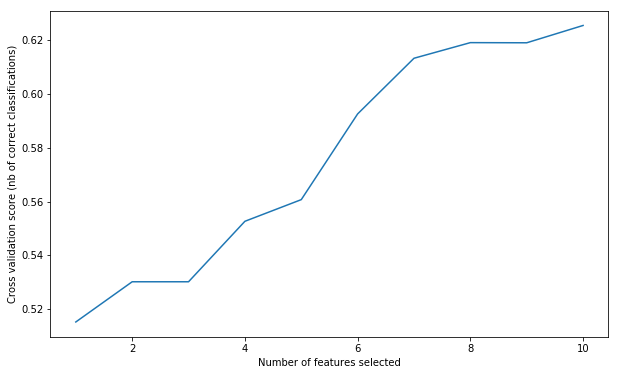

In [40]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=5, scoring='accuracy', n_jobs=-2)
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### Analysis

From our results, it seems as though the strongest predictors for the outcome based on logistic regression is the goal, followed by the duration, year, name length. It is able to predict the outcome 66.8% of the time in the testing dataset. Not bad, but let’s see if our ensemble methods can fare any better.

## Random Forest Classifier

The second model that I will utilize is the random forest model, aka "The Black Box". This is a far more complex and opaque model than logistic regression, and many other models. The reason that we want to try using a random forest classifier is because this model constructs a multitude of decision trees that randomly classifies subsets of the data into bins. This ensemble method runs these in parallel and vote to determine the single best model. 

In [41]:
# Constructing the shape of our decision tree
rfc = RandomForestClassifier(n_jobs=-2)

# Fit model to data
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
# Setting up parameters for the random forest
param_grid = {'max_features': ['sqrt'],
              'n_estimators' : [20,30,40,50],
              'max_depth' : [4, 8, 12],
              'min_samples_leaf' : [4, 8, 12]}

# Run grid search to find ideal parameters
rfc_grid = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-2)

# Fit the best parameters to our model
start_time = timeit.default_timer()
rfc_grid.fit(X_train, y_train)
elapsed_rfc = timeit.default_timer() - start_time

# Return model scores
print(rfc_grid.best_params_)
print(rfc_grid.best_score_)

{'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 50}
0.6584224539801325


In [43]:
# Predict outcome using random forest model
y_pred = rfc_grid.predict(X_test)

In [44]:
# Create a confusion matrix
confusion_matrix(y_test, y_pred)

array([[15269,  8923],
       [ 7732, 16526]], dtype=int64)

In [45]:
# Print model statisitcs
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.66      0.63      0.65     24192
          1       0.65      0.68      0.66     24258

avg / total       0.66      0.66      0.66     48450



In [46]:
# Cross validation test with 10 samples
rfc_cross_val = cross_val_score(rfc_grid, X_train, y_train, cv=5, n_jobs=-2)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(rfc_cross_val.mean(), rfc_cross_val.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.65850(+/- 0.01)


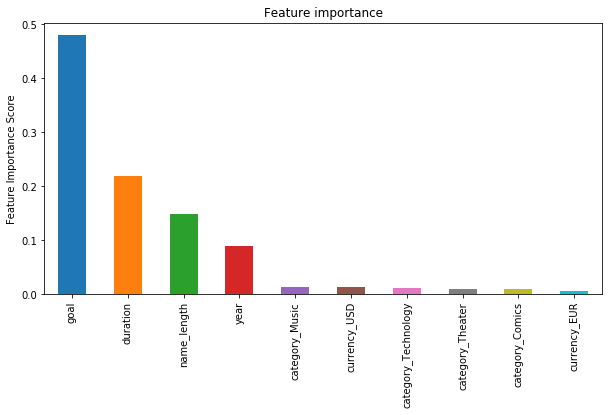

In [47]:
plt.rcParams['figure.figsize'] = [10,5]

# Plot feature importances for random forest model
rfc_features = pd.Series(rfc.feature_importances_, X_train.columns).sort_values(ascending=False).head(15)
rfc_features.plot(kind='bar', title = 'Feature importance')
plt.ylabel('Feature Importance Score')
plt.show()

### Analysis

With our random forest classifier, we are able to see that once again, the goal is the most important feature for determining the success of a project, followed by the duration, name length, and year. Our model did take a lot longer to run as the best model demanded a large number of estimators, 50, and a fairly deep length at up to 12 splits.

# Gradient Boosting Classifier

Now for the last model in this project, gradient boosting. Compared to the previous random forest mode, the gradient boosting model instead runs weaker models in succession and build upon the last. What we hope to see is that our relatively weak predictors can be fixed to allow for a much stronger predictive model in the end.

In [48]:
# Creating the gradient boosting classifer
gbc = ensemble.GradientBoostingClassifier()

gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [49]:
# Parameters for gradient boosting classifier
param_grid  = {'loss':['deviance'],
               'max_features': ['sqrt'],
               'n_estimators': [100,200,400],
               'max_depth': [4, 8, 12],
               "min_samples_leaf" : [4, 8, 12]}

# Run grid search to find ideal parameters
gbc_grid = GridSearchCV(gbc, param_grid = param_grid, n_jobs=-2)

# Initialize and fit the model.
start_time = timeit.default_timer()
gbc_grid.fit(X_train, y_train)
elapsed_gbc = timeit.default_timer() - start_time

# Return best parameters and best score
print('Best parameters:')
print(gbc_grid.best_params_)
print('Best Score:')
print(gbc_grid.best_score_)

Best parameters:
{'loss': 'deviance', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 400}
Best Score:
0.6782987907898345


In [50]:
# Predict outcome using gradient boosting classifier
y_pred = rfc_grid.predict(X_test)

In [51]:
# Create a confusion matrix
confusion_matrix(y_test, y_pred)

array([[15269,  8923],
       [ 7732, 16526]], dtype=int64)

In [52]:
# Print model statisitcs
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.66      0.63      0.65     24192
          1       0.65      0.68      0.66     24258

avg / total       0.66      0.66      0.66     48450



In [53]:
# Cross validation test
gbc_cross_val = cross_val_score(gbc_grid, X_train, y_train, cv=5, n_jobs=-2)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(gbc_cross_val.mean(), gbc_cross_val.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.68672(+/- 0.01)


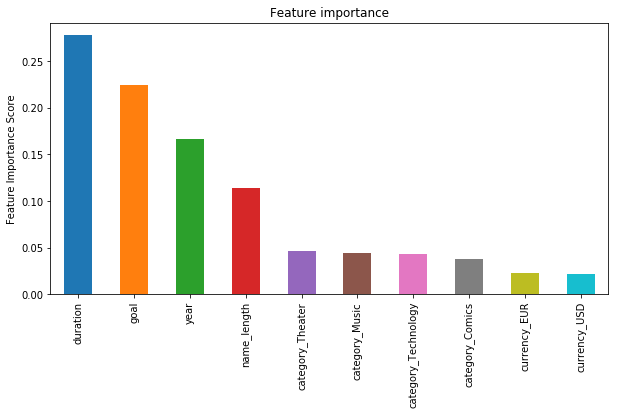

In [54]:
# Plot feature importances for gradient boosting classifier
gbc_features = pd.Series(gbc.feature_importances_, X_train.columns).sort_values(ascending=False).head(15)
gbc_features.plot(kind='bar', title = 'Feature importance')
plt.ylabel('Feature Importance Score')
plt.show()

### Analysis

So, it seems as though the longer the model runs, the more accurate it becomes. In our gradient boosting classifier, we have the highest accuracy at 69.2%, but also the longest runtime. The order of feature importance is a little different here as our gradient boosting classifier values duration more than goal, then year and name length again. Unlike the other two models though, gradient boosting classifier has more emphasis on our weaker predictors like category and currency.

# Model Comparison

In [55]:
print('Logistic regression accuracy: {:.5f}(+/- {:.2f})'.format(lr_cross_val.mean(), lr_cross_val.std()*2))
print('Logistic regression runtime: {} \n'.format(elapsed_lr))
print('Random forest accuracy: {:.5f}(+/- {:.2f})'.format(rfc_cross_val.mean(), rfc_cross_val.std()*2))
print('Random forest runtime: {} \n'.format(elapsed_rfc))
print('Gradient boosting classifier accuracy: {:.5f}(+/- {:.2f})'.format(gbc_cross_val.mean(), gbc_cross_val.std()*2))
print('Gradient boosting classifier runtime: {} '.format(elapsed_gbc))

Logistic regression accuracy: 0.62560(+/- 0.01)
Logistic regression runtime: 0.0001336549999990666 

Random forest accuracy: 0.65850(+/- 0.01)
Random forest runtime: 166.19763523700001 

Gradient boosting classifier accuracy: 0.68672(+/- 0.01)
Gradient boosting classifier runtime: 1286.8462718819997 


# Conclusion

All 3 of the models in this project agree that the goal amount and duration are the most important factors to determine the success of a project. Now, all of these variables do play a part in determining the success of a project, so it is still in the creator's best interest to acknowledge the outcome in relation to these variables.

# Source:
Kickstarter Data Page - 
https://www.kaggle.com/kemical/kickstarter-projects/data

In [56]:
get_ipython().run_cell_magic('html', '', '<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>')